# Anexo 1

**Conclusión:** Los tres modelos de U-Net, ya sea sin backbone o utilizando ResNet y EfficientNet, no funcionan bien para la segmentación de mandíbula debido a nuestros recursos computacionales limitados, lo que impide aumentar el tamaño del lote más allá de 4. Por lo tanto, ajustar otros hiperparámetros no ha logrado mejorar el índice dice por encima de 0.48

## Importar bibliotecas necesarias, montar googl drive

In [ ]:
%%capture
!pip install --upgrade tensorflow

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Concatenate, Cropping2D, ZeroPadding2D, UpSampling2D, Input, MaxPooling2D, Dropout, Reshape, ConvLSTM2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, Concatenate, BatchNormalization, Activation
import nibabel as nib
from tqdm import tqdm
import cv2
import nibabel as nib
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, BatchNormalization, Activation, Reshape, ConvLSTM2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU


In [2]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
main_dir = '/content/drive/MyDrive/saros/UNet'
train_image_nii ='/content/drive/MyDrive/saros/nnUNet/nnUNet_raw/Dataset003_ToothFairy2/imagesTr'  #'/train/images_nii'
train_image_png = main_dir + '/train/images_png'
train_labels_nii = '/content/drive/MyDrive/saros/nnUNet/nnUNet_raw/Dataset003_ToothFairy2/labelsTr' #'/train/labels_nii'
train_labels_png= main_dir + '/train/labels_png'

train_labels_png_2_class = main_dir + '/train/labels_png_2_class'

**Funciones**

Función para graficar la pérdida de entrenamiento y validación, así como la precisión (MeanIoU)

In [4]:
def plot_training_history(history, metrica, val_metrica):
    # Obtener datos del historial de entrenamiento
    history_dict = history.history

    # Crear una figura para los gráficos
    plt.figure(figsize=(12, 4))

    # Gráfico de pérdida (loss)
    plt.subplot(1, 2, 1)
    plt.plot(history_dict['loss'], label='Entrenamiento')
    plt.plot(history_dict['val_loss'], label='Validación')
    plt.title('Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Gráfico de precisión (MeanIoU)
    plt.subplot(1, 2, 2)
    plt.plot(history_dict[metrica], label='Entrenamiento')
    plt.plot(history_dict[val_metrica], label='Validación')
    plt.title('MeanIoU')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Mostrar los gráficos
    plt.show()

Funcion para visualizar una imagen aleatoria del lote de validación junto con su etiqueta original y la máscara predicha por tu modelo

In [5]:
def visualize_predictions(model, val_gen):
    # Obtener un lote de datos de validación
    x_val, y_val = next(val_gen)

    # Hacer predicciones
    predictions = model.predict(x_val)

    # Seleccionar una imagen aleatoria del lote
    idx = np.random.randint(0, len(x_val))

    # Obtener la imagen original, la etiqueta original y la máscara predicha
    original_image = x_val[idx]
    original_label = y_val[idx]
    predicted_mask = predictions[idx]

    binary_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Visualizar la imagen original, la etiqueta original y la máscara predicha
    plt.figure(figsize=(15, 5))

    # Imagen original
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Imagen Original')
    plt.axis('off')

    # Etiqueta original
    plt.subplot(1, 3, 2)
    plt.imshow(original_label, cmap='gray')
    plt.title('Etiqueta Original')
    plt.axis('off')

    # Máscara predicha
    plt.subplot(1, 3, 3)
    plt.imshow(binary_mask, cmap='gray')
    plt.title('Máscara Predicha')
    plt.axis('off')

    plt.show()

## Transformar los imagenes  de "nii" a "png"

Transformar NII.gz a Png

In [ ]:
def normalize_image(image):
    # Normalizar los datos al rango de 0 a 255
    normalized_data = ((image - np.min(image)) / (np.max(image) - np.min(image))) * 255
    # Convertir a uint8
    normalized_data = normalized_data.astype(np.uint8)
    return normalized_data

def save_nii_as_png(load_dir, save_dir, flag=1):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    filenames = os.listdir(load_dir)

    for filename in filenames:
        if filename.endswith('.nii.gz'):
            try:
                path = os.path.join(load_dir, filename)
                new_path = os.path.join(save_dir, filename.replace('.nii.gz', '.png'))
                nii_img = nib.load(path)
                nii_data = nii_img.get_fdata()

                # Si flag es 0, la clase especial se codifica como blanco, de lo contrario, se mantiene sin cambios
                if flag == 0:
                    colored_image = np.where(nii_data == 1, 1, 0)
                else:
                    colored_image = nii_data

                # Normalizar la imagen si es necesario
                colored_image = normalize_image(colored_image)

                # Guardar la imagen
                cv2.imwrite(new_path, colored_image)
                # Guardar la imagen
                cv2.imwrite(new_path, colored_image)

            except Exception as e:
                print(f"Error processing {filename}: {e}")
                continue

In [ ]:
# Usar la función para convertir máscaras NIfTI a PNG
save_nii_as_png(train_image_nii, train_image_png, 1)
save_nii_as_png(train_labels_nii, train_labels_png, 0)


<ipython-input-23-12d6ed6bd6e0>:3: RuntimeWarning: invalid value encountered in divide
  normalized_data = ((image - np.min(image)) / (np.max(image) - np.min(image))) * 255
<ipython-input-23-12d6ed6bd6e0>:5: RuntimeWarning: invalid value encountered in cast
  normalized_data = normalized_data.astype(np.uint8)


In [ ]:
os.path.exists('/content/drive/MyDrive/saros/UNet/train/imagesTR')

False

## DataGenerator

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

main_dir = '/content/drive/MyDrive/saros/UNet/train'
val_dir = '/content/drive/MyDrive/saros/UNet/val'
shape_1 = 512
batch_size_train = 4
batch_size_val = 2

# Data augmentation configuration
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='nearest')

# Image and mask data generators with data augmentation
image_datagen = ImageDataGenerator(**data_gen_args, rescale=1./255)
mask_datagen = ImageDataGenerator(**data_gen_args, rescale=1./255)

# Seed for random transformation consistency
seed = 1

# Flow from directory for images
image_generator = image_datagen.flow_from_directory(
    main_dir,
    classes=['images_png'],
    class_mode=None,  # No class mode since there are no subdirectories
    seed=seed,
    target_size=(shape_1, shape_1),  # Adjust as needed
    batch_size=batch_size_train,
    color_mode='rgb',  # or 'grayscale' based on your images
)

# Flow from directory for masks
mask_generator = mask_datagen.flow_from_directory(
    main_dir,
    classes=['labels_png'],
    class_mode=None,  # No class mode since there are no subdirectories
    seed=seed,
    target_size=(shape_1, shape_1),  # Adjust as needed
    batch_size=batch_size_train,
    color_mode='grayscale',  # Masks are typically grayscale
)

def train_generator(image_gen, mask_gen):
    while True:
        image_batch = next(image_gen)
        mask_batch = next(mask_gen)
        yield (image_batch, mask_batch)

# Crear generador de entrenamiento
train_gen = train_generator(image_generator, mask_generator)

# Validation generators
image_datagen_val = ImageDataGenerator(rescale=1./255)
mask_datagen_val = ImageDataGenerator(rescale=1./255)

image_generator_val = image_datagen_val.flow_from_directory(
    val_dir,
    classes=['images_png'],
    class_mode=None,
    seed=seed,
    target_size=(shape_1, shape_1),
    batch_size=batch_size_val,
    color_mode='rgb',
)

mask_generator_val = mask_datagen_val.flow_from_directory(
    val_dir,
    classes=['labels_png'],
    class_mode=None,
    seed=seed,
    target_size=(shape_1, shape_1),
    batch_size=batch_size_val,
    color_mode='grayscale',
)

def val_generator(image_gen, mask_gen):
    while True:
        image_batch = next(image_gen)
        mask_batch = next(mask_gen)
        yield (image_batch, mask_batch)

val_gen = val_generator(image_generator_val, mask_generator_val)

Found 1620 images belonging to 1 classes.
Found 1620 images belonging to 1 classes.
Found 7 images belonging to 1 classes.
Found 7 images belonging to 1 classes.


## Modelo 1 Unet

Descripción: Utiliza un diseño complejo con múltiples caminos paralelos (D1, D2, D3) y ConvLSTM para capturar características a diferentes niveles de abstracción.

Ventajas: Alta capacidad de capturar detalles contextuales debido a su estructura modular.

Desventajas: Mayor complejidad y requerimientos computacionales, potencial riesgo de sobreajuste.

https://github.com/rezazad68/BCDU-Net/blob/master/README.md

In [7]:
from tensorflow.keras.metrics import MeanIoU
def BCDU_net_D3(input_size=(shape_1, shape_1, 3)):
    N = input_size[0]
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

    # D1
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)

    # D2
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop4_1)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4_2)
    drop4_2 = Dropout(0.5)(conv4_2)

    # D3
    merge_dense = concatenate([drop4_2, drop4_1], axis=3)
    conv4_3 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge_dense)
    conv4_3 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)

    # Upsampling and Convolution
    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same', kernel_initializer='he_normal')(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6 = concatenate([x1, x2], axis=1)
    merge6 = ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', return_sequences=False, go_backwards=True, kernel_initializer='he_normal')(merge6)

    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same', kernel_initializer='he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7 = concatenate([x1, x2], axis=1)
    merge7 = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=False, go_backwards=True, kernel_initializer='he_normal')(merge7)

    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same', kernel_initializer='he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8 = concatenate([x1, x2], axis=1)
    merge8 = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=False, go_backwards=True, kernel_initializer='he_normal')(merge8)

    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    conv9 = Conv2D(1, 1, activation='sigmoid')(conv8)


    model = Model(inputs, conv9)
    model.compile(optimizer=Adam(learning_rate=3e-2), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)],run_eagerly=True)
    return model

In [8]:
model_BCDU = BCDU_net_D3(input_size = (shape_1,shape_1,3))

In [9]:
# Entrenar el modelo
history = model_BCDU.fit(
    train_gen,
    steps_per_epoch=20,
    epochs=20,
    validation_data=val_gen,
    validation_steps=3,
    verbose=1
)

Epoch 1/20


20/20 [==============================] - 88s 2s/step - loss: 0.4323 - mean_io_u: 0.4864 - val_loss: 0.3400 - val_mean_io_u: 0.4736
Epoch 2/20
20/20 [==============================] - 22s 1s/step - loss: 0.1744 - mean_io_u: 0.4817 - val_loss: 0.1738 - val_mean_io_u: 0.4768
Epoch 3/20
20/20 [==============================] - 27s 1s/step - loss: 0.1381 - mean_io_u: 0.4839 - val_loss: 0.1948 - val_mean_io_u: 0.4728
Epoch 4/20
20/20 [==============================] - 23s 1s/step - loss: 0.1472 - mean_io_u: 0.4832 - val_loss: 0.2297 - val_mean_io_u: 0.4728
Epoch 5/20
20/20 [==============================] - 26s 1s/step - loss: 0.1383 - mean_io_u: 0.4843 - val_loss: 0.1730 - val_mean_io_u: 0.4749
Epoch 6/20
20/20 [==============================] - 25s 1s/step - loss: 0.1281 - mean_io_u: 0.4852 - val_loss: 0.2073 - val_mean_io_u: 0.4754
Epoch 7/20
20/20 [==============================] - 25s 1s/step - loss: 0.1379 - mean_io_u: 0.4841 - val_loss: 0.2162 - val_mean_io_u: 0.4681
Epoch 8/20
20/20 

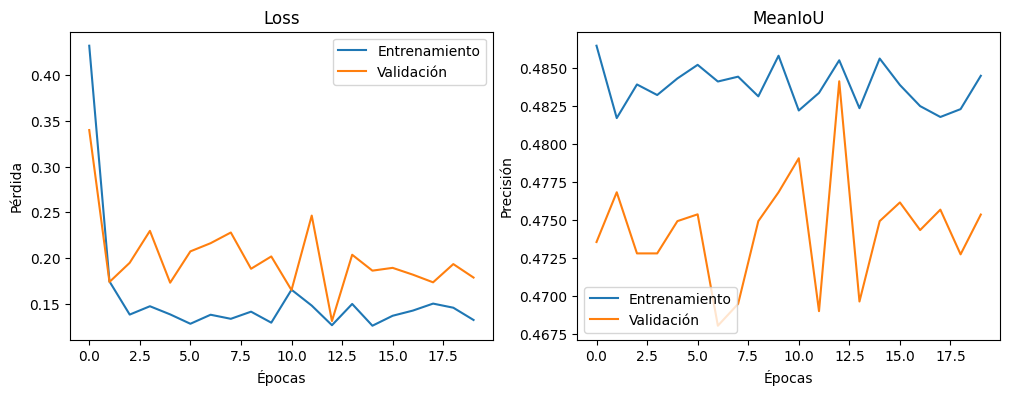

In [21]:
# Obtener datos del historial de entrenamiento
plot_training_history(history,'mean_io_u','val_mean_io_u')

1/1 [==============================] - 0s 118ms/step


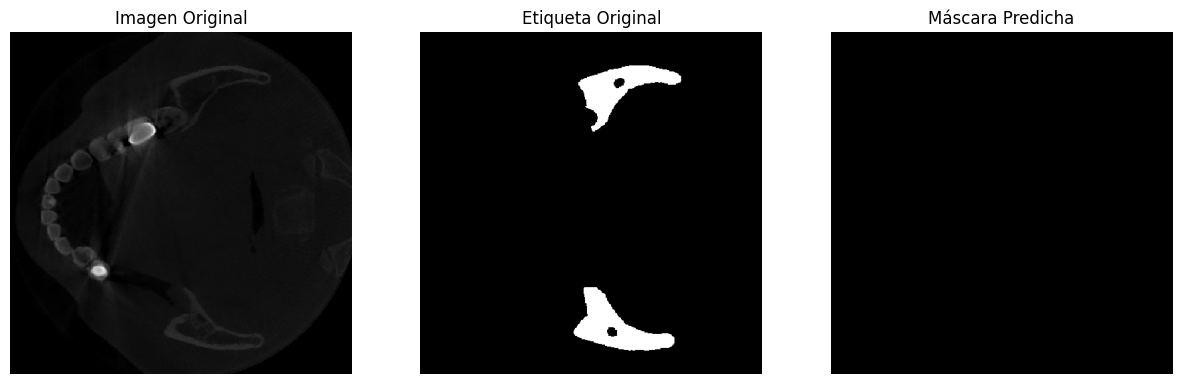

In [18]:
#visualisar imagen original, su etiqueta original y etiqueta predicha
visualize_predictions(model_BCDU, val_gen)

Guardado el modelo

In [11]:
save_path = '/content/drive/MyDrive/saros/UNet/train/model_BCDU.h5'
model_BCDU.save(save_path)
print(f'Modelo guardado en {save_path}')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Modelo guardado en /content/drive/MyDrive/saros/UNet/train/model_BCDU.h5


## Modelo 2 Unet con ResNet

Descripción: Basado en ResNet50 pre-entrenado, utiliza conexiones de salto para reconstruir la imagen.

Ventajas: Aprovecha las características profundas de ResNet50, transferencia de aprendizaje desde ImageNet.

Desventajas: Menos flexible que el Modelo 1 en términos de adaptabilidad de la arquitectura base.

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    return x

def unet_resnet(input_shape):
    inputs = Input(input_shape)

    # Cargar ResNet50 pre-entrenado sin las capas densas superiores
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # Congelar los pesos de ResNet
    for layer in resnet_base.layers:
        layer.trainable = False

    # Obtener las salidas de algunas capas específicas de ResNet
    skip_connections = [resnet_base.get_layer(layer_name).output for layer_name in ['conv1_relu', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out']]
    resnet_output = resnet_base.get_layer('conv5_block3_out').output

    # Decoder
    x = resnet_output
    num_filters = [512, 256, 128, 64]
    for i, skip_connection in enumerate(reversed(skip_connections)):
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, skip_connection])
        x = conv_block(x, num_filters=num_filters[i])

    x = UpSampling2D((2, 2))(x)
    # Capa de salida
    outputs = Conv2D(1, 1, activation='sigmoid')(x)

    # Modelo
    model = Model(inputs, outputs)

    # Compilación del modelo
    model.compile(optimizer=Adam(learning_rate=3e-4),
                  loss='binary_crossentropy',
                  metrics=[MeanIoU(num_classes=2)],run_eagerly=True)

    return model

# Uso
input_shape = (512, 512, 3)  # Define el tamaño de la entrada
model = unet_resnet(input_shape)

In [ ]:
model.summary()

In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=50,
    epochs=20,
    validation_data=val_gen,
    batch_size = batch_size_train,
    validation_steps=3,
    verbose=1
)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - loss: 0.7227 - mean_io_u_8: 0.4843 - val_loss: 1.0914 - val_mean_io_u_8: 0.4749
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - loss: 0.5935 - mean_io_u_8: 0.4825 - val_loss: 0.3501 - val_mean_io_u_8: 0.4710
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 955ms/step - loss: 0.5256 - mean_io_u_8: 0.4852 - val_loss: 0.3342 - val_mean_io_u_8: 0.4767
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 959ms/step - loss: 0.4460 - mean_io_u_8: 0.4842 - val_loss: 0.4114 - val_mean_io_u_8: 0.4736
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 960ms/step - loss: 0.3751 - mean_io_u_8: 0.4852 - val_loss: 0.5791 - val_mean_io_u_8: 0.4775
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 954ms/step - loss: 0.3120 - mean_io_u_8: 0.4846 - val_loss: 0.3709 - val_mean_io_u_8: 0.4997
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 957ms/step - loss: 0.2636 - mean_io_u_8: 0.4884 - val_loss: 0.2144 - val_mean_io_u_8: 0.4755
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 954ms/step - loss

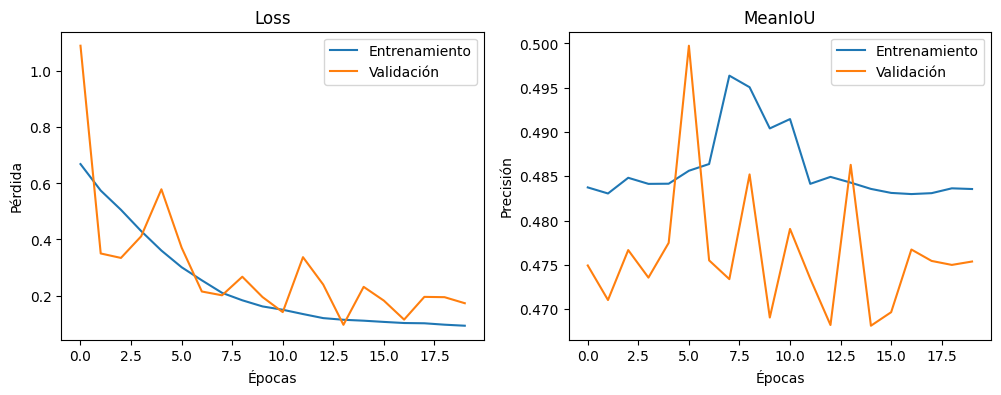

In [ ]:
# Obtener datos del historial de entrenamiento
plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


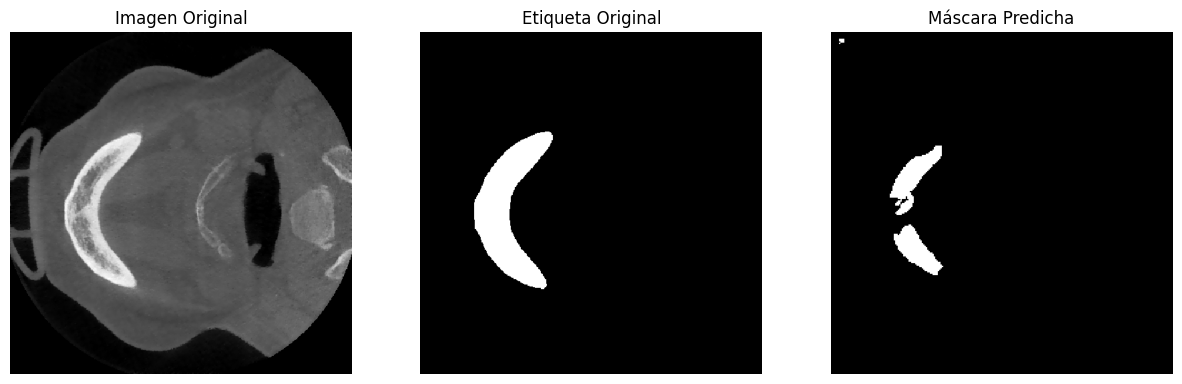

In [ ]:
#visualizar una imagen aleatoria del lote de validación junto con su etiqueta original y la máscara predicha por tu modelo
visualize_predictions(model, val_gen)

In [ ]:
save_path = '/content/drive/MyDrive/saros/UNet/train/model_Resnet_Unet.h5'
model.save(save_path)
print(f'Modelo guardado en {save_path}')

## Modelo 3 - Unet con EfficientNet

Descripción: Utiliza EfficientNetB0 pre-entrenado, conocido por su eficiencia y buen rendimiento en tareas de visión.

Ventajas: Eficiencia computacional, buen equilibrio entre rendimiento y recursos.

Desventajas: Limitado por la profundidad y capacidad de representación de EfficientNetB0 en comparación con modelos más grandes como ResNet50.

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    return x

def unet_efficientnet(input_shape):
    inputs = Input(input_shape)

    # Cargar EfficientNetB0 preentrenado sin las capas densas superiores
    efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=inputs)

    # Congelar los pesos de EfficientNet
    for layer in efficientnet_base.layers:
        layer.trainable = False

    # Obtener las salidas de algunas capas específicas de EfficientNet
    skip_connections = [efficientnet_base.get_layer(layer_name).output for layer_name in [
        'block1a_activation', 'block2b_add', 'block3b_add', 'block4b_add']]
    efficientnet_output = efficientnet_base.get_layer('top_activation').output

    # Decoder
    x = efficientnet_output
    num_filters = [512, 256, 128, 64]
    for i, skip_connection in enumerate(reversed(skip_connections)):
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, skip_connection])
        x = conv_block(x, num_filters=num_filters[i])

    x = UpSampling2D((2, 2))(x)
    # Capa de salida
    outputs = Conv2D(1, 1, activation='sigmoid')(x)

    # Modelo
    model = Model(inputs, outputs)

    # Compilación del modelo
    model.compile(optimizer=Adam(learning_rate=3e-4),
                  loss='binary_crossentropy',
                  metrics=[MeanIoU(num_classes=2)], run_eagerly=True)

    return model

# Uso
input_shape = (512, 512, 3)  # Define el tamaño de la entrada
model_unet_efficientnet = unet_efficientnet(input_shape)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model_unet_efficientnet.fit(
    train_gen,
    steps_per_epoch=20,
    epochs=20,
    validation_data=val_gen,
    batch_size=6,  # Ajusta según la capacidad de tu GPU
    validation_steps=3,
    verbose=1
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - loss: 0.7421 - mean_io_u: 0.4865 - val_loss: 3.9612 - val_mean_io_u: 0.4732
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.6620 - mean_io_u: 0.4836 - val_loss: 1.6987 - val_mean_io_u: 0.4766
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.6335 - mean_io_u: 0.4829 - val_loss: 1.7172 - val_mean_io_u: 0.4730
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.6057 - mean_io_u: 0.4854 - val_loss: 1.1119 - val_mean_io_u: 0.4728
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.5766 - mean_io_u: 0.4850 - val_loss: 0.8636 - val_mean_io_u: 0.4757
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.5484 - mean_io_u: 0.4834 - val_loss: 0.7345 - val_mean_io_u: 0.4654
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.5171 - mean_io_u: 0.4857 - val_loss: 0.7121 - val_mean_io_u: 0.4837
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.4885 - mean_io_u: 0.4836 - val_loss: 0.5963 

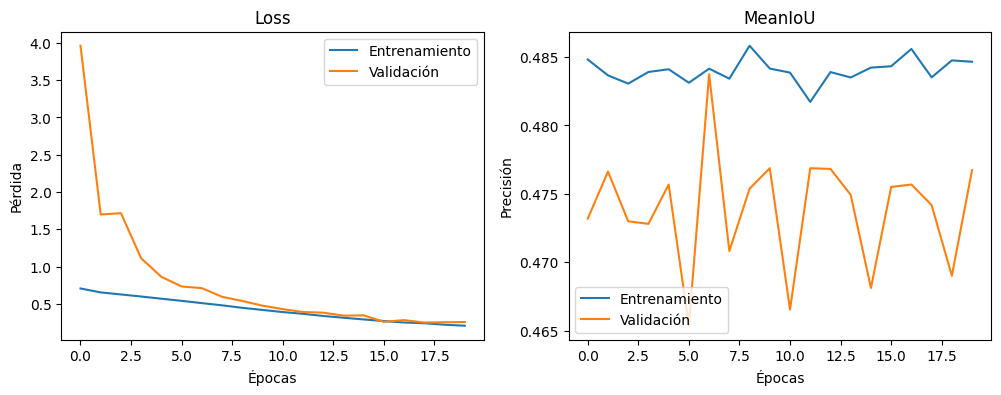

In [ ]:
# Obtener datos del historial de entrenamiento
plot_training_history(history, "mean_io_u", "val_mean_io_u")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


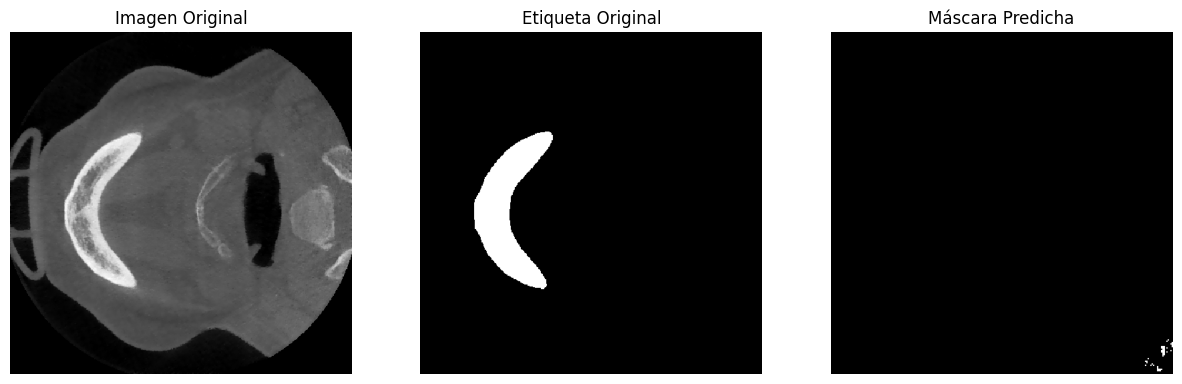

In [ ]:
#Visualizar una imagen aleatoria del lote de validación junto con su etiqueta original y la máscara predicha por tu modelo
visualize_predictions(model_unet_efficientnet, val_gen)

In [ ]:
save_path = '/content/drive/MyDrive/saros/UNet/train/model_Efficientnet_Unet.h5'
model_unet_efficientnet.save(save_path)
print(f'Modelo guardado en {save_path}')

Modelo guardado en /content/drive/MyDrive/saros/UNet/train/model_Efficientnet_Unet.h5
